Выгрузка данных о золоте, индийской рупии, нефти.<br>
данные берем за тот же период и с таким же датафреймом как в нашем очищенном датасете (2025 год, день).<br>
далее - графическая проверка корреляции

In [15]:
# !pip install yfinance --upgrade

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 1) Базовый BTC-датасет (2025, дневной) ===
btc = pd.read_csv("data_crypto_clear.csv", parse_dates=["Date"])
btc = btc.sort_values("Date").reset_index(drop=True)
btc_2025 = btc[(btc["Date"] >= "2025-01-01") & (btc["Date"] <= "2025-12-31")].copy()

start_date = btc_2025["Date"].min()
end_date   = btc_2025["Date"].max()

# === 2) Скачиваем активы одним вызовом ===
tickers = {
    "Gold": "GC=F",   # золото (фьючерсы)
    "Oil" : "CL=F",   # нефть WTI (фьючерсы)
    "INR" : "INR=X",  # USD/INR (рост = ослабление рупии)
}
raw = yf.download(list(tickers.values()),
                  start=start_date, end=end_date, interval="1d",
                  progress=False, group_by="column")

# Вытаскиваем "Close" корректно для случая MultiIndex-колонок
# (при нескольких тикерах yfinance делает столбцы с уровнями)
if isinstance(raw.columns, pd.MultiIndex):
    close_assets = raw["Close"].copy()
else:
    # на всякий случай, если вдруг вернулся одиночный уровень
    close_assets = raw[["Close"]].copy()

# Переименовываем колонки на удобные имена
close_assets = close_assets.rename(columns={v: k for k, v in tickers.items()})

# Индекс -> столбец Date, убираем TZ, сортируем
close_assets = close_assets.copy()
close_assets.index = pd.to_datetime(close_assets.index)
# если индекс вдруг TZ-aware, обнулим таймзону
try:
    close_assets.index = close_assets.index.tz_localize(None)
except Exception:
    pass
close_assets = close_assets.sort_index().reset_index().rename(columns={"index": "Date"})

# === 3) Собираем единый датафрейм по датам ===
btc_close = btc_2025[["Date", "Close"]].rename(columns={"Close": "BTC"})
merged = btc_close.merge(close_assets, on="Date", how="inner")

print("Диапазон дат:", merged["Date"].min().date(), "—", merged["Date"].max().date())
display(merged.head(15))
display(merged.info())

Диапазон дат: 2025-01-03 — 2025-08-15


/var/folders/gc/7bxqzl8d4kj4nxgzh387r3sm0000gn/T/ipykernel_15892/3260171591.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(list(tickers.values()),


,Date,BTC,Oil,Gold,INR
0,2025-01-03,98107.429688,73.959999,2645.000000,85.804001
1,2025-01-06,102078.085938,73.559998,2638.399902,85.759003
2,2025-01-07,96922.703125,74.250000,2656.699951,85.680702
3,2025-01-08,95043.523438,73.320000,2664.500000,85.806503
4,2025-01-09,92484.039062,73.919998,2683.800049,85.907501
5,2025-01-10,94701.453125,76.570000,2708.500000,85.919998
6,2025-01-13,94516.523438,78.820000,2673.500000,86.188004
7,2025-01-14,96534.046875,77.500000,2677.500000,86.650597
8,2025-01-15,100504.492188,80.040001,2712.500000,86.535400
9,2025-01-16,99756.906250,78.680000,2746.399902,86.431000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    160 non-null    datetime64[ns]
 1   BTC     160 non-null    float64       
 2   Oil     156 non-null    float64       
 3   Gold    156 non-null    float64       
 4   INR     159 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 6.4 KB


None

**корреляция между признаками получившего датасета**

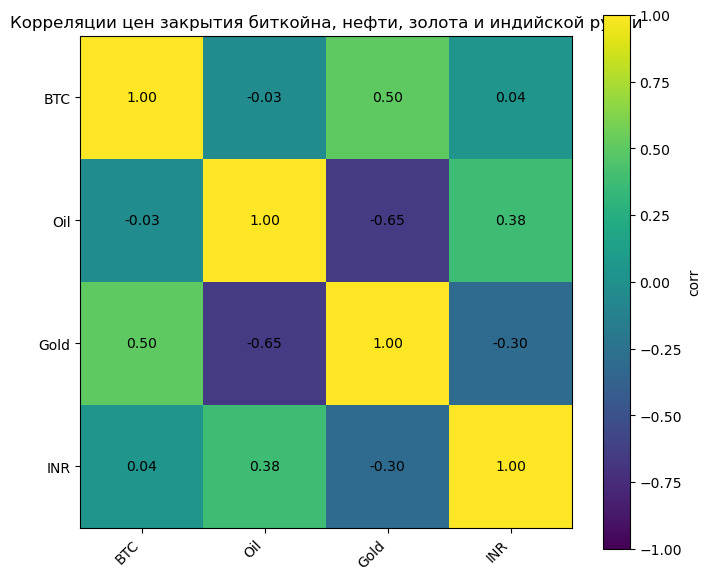

In [18]:
# === Тепловая карта корреляции ===
corr_df = merged.drop(columns='Date')
corr_mat = corr_df.corr()

plt.figure(figsize=(7,6))
im = plt.imshow(corr_mat, vmin=-1, vmax=1)
plt.title("Корреляции цен закрытия биткойна, нефти, золота и индийской рупии")
plt.colorbar(im, label="corr")

labels = corr_mat.columns.tolist()
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.yticks(range(len(labels)), labels)

# подписи значений
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, f"{corr_mat.iloc[i, j]:.2f}", ha="center", va="center")

plt.tight_layout()
plt.show()

**Вывод**:<br>
корреляция между биткойном, нефтью, золотом и индийской рупией отсутствует => нецелесообразно использовать данные фонды для предсказания.